# **STOCK PRICE PREDICTOR**

# **1. IMPORTING LIBRARIES**

In [1]:
!pip install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import mplfinance as mpf

# **DATA READING AND PREPROCESSING**

In [4]:
df = pd.read_csv('/content/Apple Stock Price History.csv')

In [5]:
# df.index = pd.to_datetime(df.Time,format='%d/%m/%Y %H:%M')
# df = df['2023-01-01':]
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df = df.rename(columns={'Price': 'Close'})
df.head()

,Close,Open,High,Low
Date,,,,
2025-06-02,200.53,200.28,202.10,200.13
2025-05-30,200.85,199.37,201.96,196.78
2025-05-29,199.95,203.57,203.81,198.51
2025-05-28,200.42,200.59,202.73,199.90
2025-05-27,200.21,198.30,200.74,197.43


In [6]:
# df.isnull().sum()
# df.describe()
# df.info()
# df.columns
df.shape
# df.duplicated().sum()

(1108, 4)

In [8]:
# df = df.drop(['Vol.','Change %'],axis=1)

# **DATA VISUALIZATION**

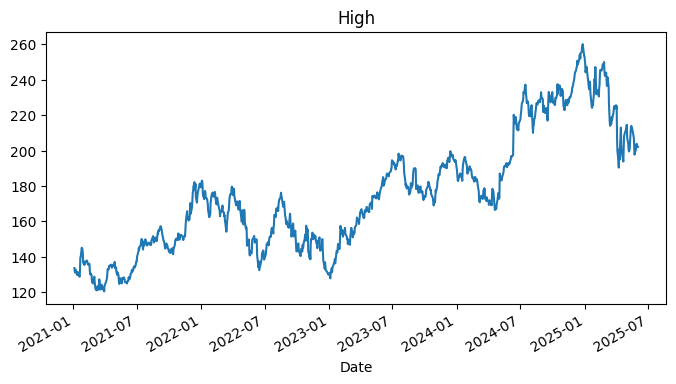

In [9]:
df['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.show()

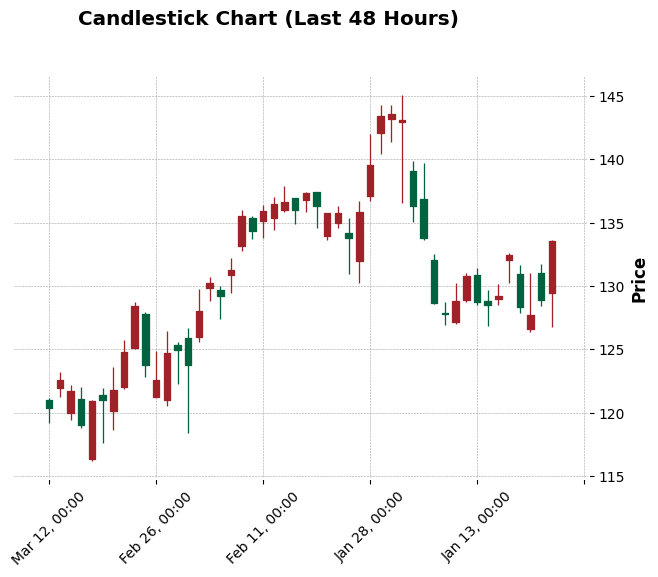

In [10]:
ohlc_df = df[['Open', 'High', 'Low', 'Close']].copy()
ohlc_df.index.name = 'Date'

mpf.plot(ohlc_df[-48:], type='candle', style='charles', title='Candlestick Chart (Last 48 Hours)', ylabel='Price')

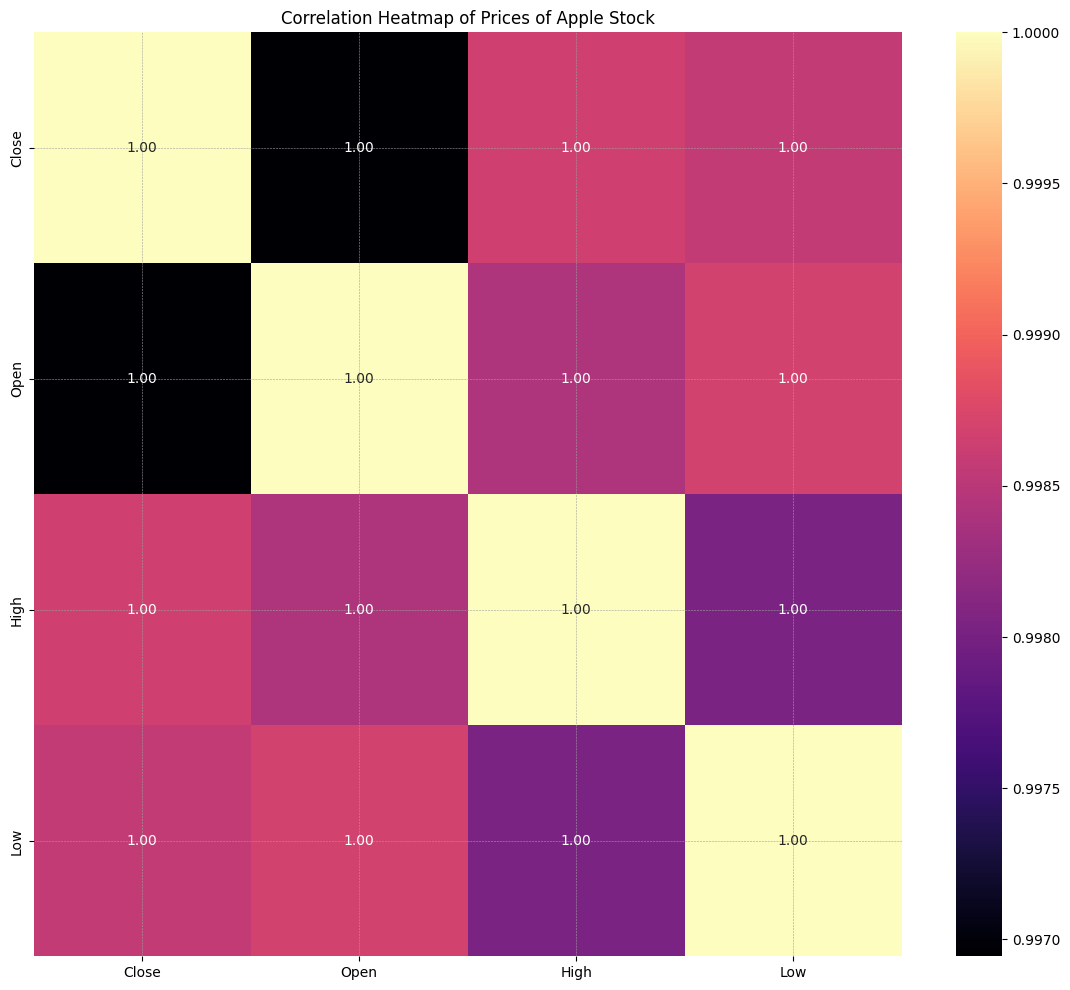

In [12]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Heatmap of Prices of Apple Stock')
plt.show()

# **TRAIN - TEST SPLIT**

In [13]:
features = ['Open','Low','Close']
target = ['High']

In [14]:
train = df.loc[df.index < '2025-01-01']
test = df.loc[df.index >= '2025-01-01']
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

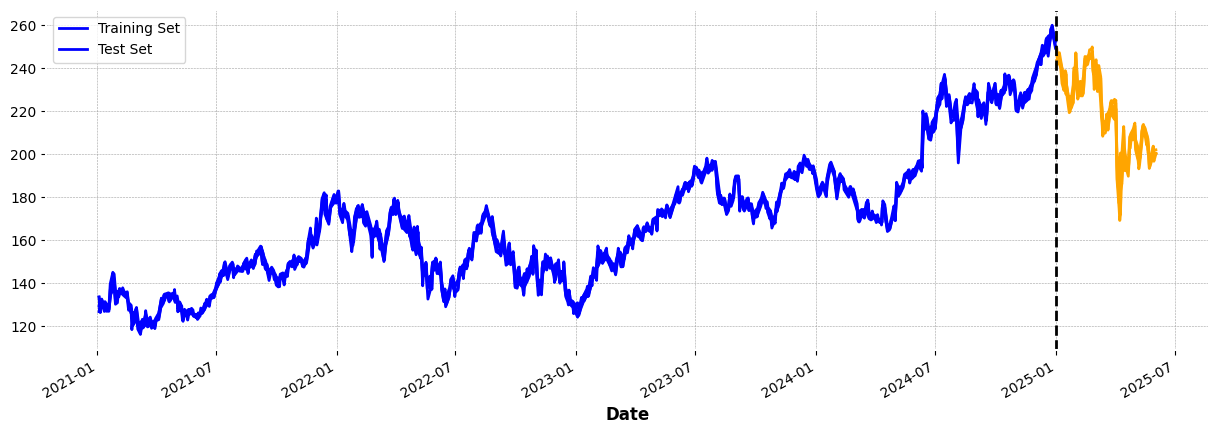

In [15]:
fig , ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'Training Set',color='blue')
test.plot(ax=ax, label = 'Test Set',color='orange')
ax.axvline('2025-01-01',color = 'black',ls = '--')
ax.legend(['Training Set','Test Set'])
plt.show()

In [16]:
# X_train
# y_train
# X_test
# y_test
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1005, 3), (1005, 1), (103, 3), (103, 1))

# **MODEL TRAINING (RANDOM FOREST REGRESSOR)**

In [17]:
rfr = RandomForestRegressor(n_estimators=100,max_depth=6,random_state=42)

In [18]:
rfr.fit(X_train,y_train)
rfr.score(X_train,y_train)

0.9994169221046716

In [19]:
predictions = rfr.predict(X_test)

In [20]:
model_accuracy = rfr.score(X_test,y_test)*100

# **EVALUATION METRICS**

In [21]:
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print("Mean Absolute Error:",round(mae,2))
print("Mean Squared Error:",round(mse,2))
print("Root Mean Squared Error:",round(rmse,2))
print("R2 Score",round(r2,4))
print('Model Accuracy on test data:',round(model_accuracy,2))

Mean Absolute Error: 2.46
Mean Squared Error: 14.64
Root Mean Squared Error: 3.83
R2 Score 0.9489
Model Accuracy on test data: 94.89


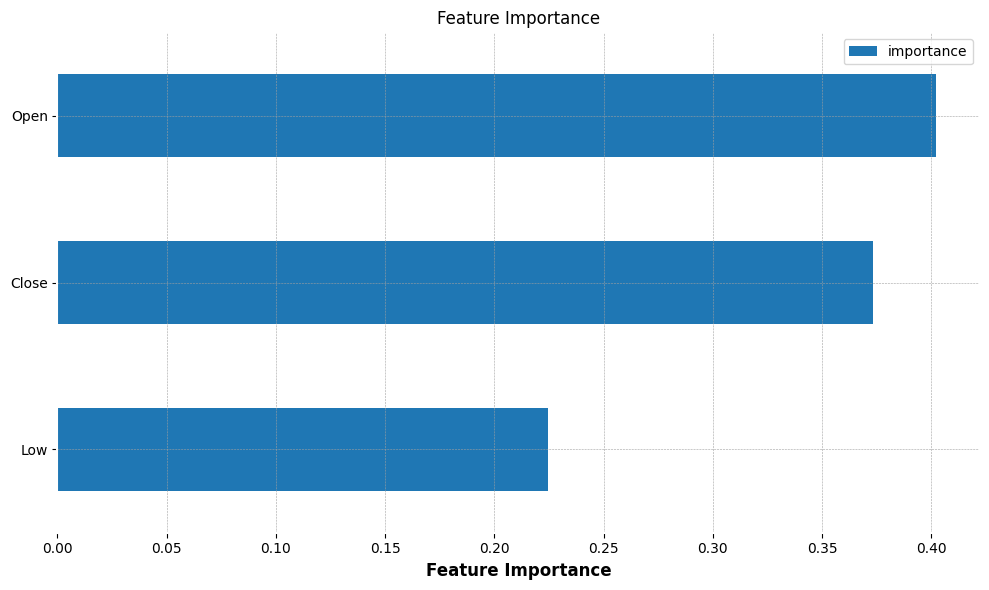

In [22]:
fi = pd.DataFrame(data=rfr.feature_importances_,
                  index=X_train.columns,
                  columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(10, 6))
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

In [26]:
extended_df = df
preds = rfr.predict(X_test)
pred_df = pd.DataFrame(preds, index=X_test.index, columns=['Predictions'])
extended_df = extended_df.merge(pred_df, how='left', left_index=True, right_index=True)

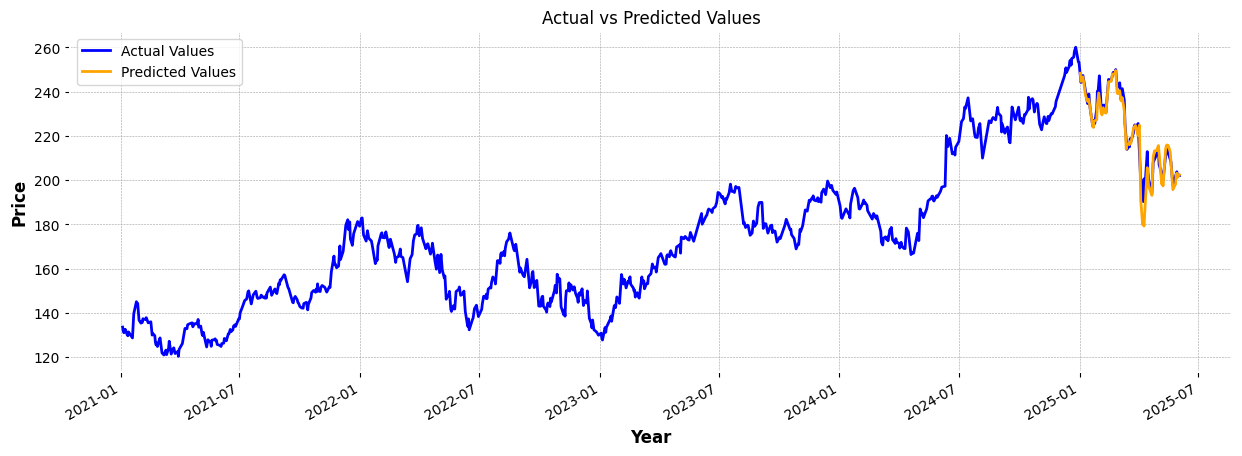

In [27]:
ax = extended_df['High'].plot(figsize=(15, 5), color='blue')
extended_df['Predictions'].plot(ax=ax, color='orange')
plt.legend(['Actual Values', 'Predicted Values'])
plt.xlabel('Year')
plt.ylabel('Price')
ax.set_title("Actual vs Predicted Values")
plt.show()

In [28]:
#Viewing results according to latest dates
extended_df[extended_df.index > '2025-05-23']

,Close,Open,High,Low,Predictions
Date,,,,,
2025-06-02,200.53,200.28,202.10,200.13,202.492945
2025-05-30,200.85,199.37,201.96,196.78,201.288426
2025-05-29,199.95,203.57,203.81,198.51,203.183704
2025-05-28,200.42,200.59,202.73,199.90,202.492945
2025-05-27,200.21,198.30,200.74,197.43,198.213686


In [ ]:
import pickle
filename = 'rfr_stock_predictor.pkl'
pickle.dump(rfr, open(filename, 'wb'))